In [ ]:
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
   

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob
from tqdm.notebook import tqdm
from itertools import combinations
from collections import defaultdict
import h5py
import kornia
from kornia.feature import DISK
import torch
from concurrent.futures import ThreadPoolExecutor

In [ ]:
# comment out if not using google colab
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Image_matching_3d
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Image_matching_3d
cluster_deploy.py	  feature_matching	   main.py
data_preprocess		  flann_with_disk_outputs  README.md
disk_descriptors_outputs  image_matching.ipynb	   reconstruction
evaluation		  __init__.py		   requirements.txt
feature_descriptors	  LICENSE


In [ ]:
from data_preprocess.image_matching_dataset import ImageMatchingDataset
import torchvision.transforms as transforms
import torch
from PIL import Image

from feature_descriptors.disk_flann_descriptor import get_disk_outputs
from feature_matching.flann_matcher import flann_matcher, convert_result_into_opencv

In [ ]:
data_path = "/content/drive/MyDrive/image-matching-challenge-2025"

# if not using google colab:
# data_path = "../../image-matching-challenge-2025"

train_path = data_path + "/train"
train_labels_path = data_path + "/train_labels.csv"
train_thresholds_path = data_path + "/train_thresholds.csv"
sample_submission_path = data_path + "/sample_submission.csv"
test_path = data_path + "/test"

disk_outputs_dir = "disk_descriptors_outputs"
flann_outputs_dir = "flann_with_disk_outputs"

In [ ]:
train_dataset = ImageMatchingDataset(labels_path=train_labels_path, root_dir=train_path,
                                   transform=transforms.Compose([
                                   transforms.ToTensor(),
                               ]))

datasets_name = train_dataset.labels_df["dataset"].unique()
datasets_name

array(['imc2023_haiper', 'imc2023_heritage',
       'imc2023_theather_imc2024_church', 'imc2024_dioscuri_baalshamin',
       'imc2024_lizard_pond', 'pt_brandenburg_british_buckingham',
       'pt_piazzasanmarco_grandplace', 'pt_sacrecoeur_trevi_tajmahal',
       'pt_stpeters_stpauls', 'amy_gardens', 'fbk_vineyard', 'ETs',
       'stairs'], dtype=object)

In [ ]:
def get_indices_by_dataset(dataset, dataset_name):
  index = []
  for idx, row in train_dataset.labels_df.iterrows():
    if row["dataset"] == dataset_name:
      index.append(idx)

  return index

# def run_disk(dataset, dataset_indices, device):
#   disk = DISK.from_pretrained("depth").to(device)
#   features = []
#   for i, idx in enumerate(dataset_indices):
#     sample = dataset[idx]
#     img = sample["image"].unsqueeze(0).to(device)
#     feature = disk(img, pad_if_not_divisible=True)
#     features.append({
#         "image_name": sample["image_name"],
#         "feature": feature
#     })

#   return features

# def convert_result_into_opencv(features):
#   features_np = []

#   for i, ft in enumerate(features):
#     feature = ft["feature"]
#     desc = feature[0].descriptors
#     desc_np = desc.cpu().detach().numpy().astype("float32")
#     kps = feature[0].keypoints
#     kps_np = [cv.KeyPoint(x=float(x), y=float(y), size=1) for x, y in kps.cpu().numpy()]
#     features_np.append({
#         "image_name": ft["image_name"],
#         "keypoints": kps_np,
#         "descriptors": desc_np
#     })

  return features_np

def get_pairs(num_image):
  return list(combinations(range(num_image), 2))

def run_flann(descriptor_filename, pairs, num_workers=8):
  results = []
  with ThreadPoolExecutor(max_workers=num_workers) as pool:
    for match, i, j in pool.map(lambda p: flann_matcher(*p, descriptor_filename, descriptor="disk"), pairs):
      results.append({
          "pair": (i, j),
          "image1_name": torch.load(descriptor_filename, weights_only=False)[i]["image_name"],
          "image2_name": torch.load(descriptor_filename, weights_only=False)[j]["image_name"],
          "good_matches": match
      })

  return results

def save_flann_output(results, filename):
  with h5py.File(filename, "w") as f:
    for r in results:
      pair = r["pair"]
      matches_arr = np.array([
          (m.queryIdx, m.trainIdx, m.imgIdx, m.distance) for m in r["good_matches"]
      ])
      images_name = [r["image1_name"], r["image2_name"]]

      group = f.create_group(str(pair))
      group.create_dataset("pair", data=pair)
      dt = h5py.string_dtype(encoding="utf-8")
      group.create_dataset("images_name", data=np.array(images_name, dtype=object), dtype=dt)
      group.create_dataset("good_matches", data=matches_arr)

def load_flann_output(filepath, pair_idx):
  with h5py.File(filepath, "r") as f:
    group = f[pair_idx]
    matches_arr = group["good_matches"][:]
    images_name = group["images_name"].asstr()[:]
    pair = group["pair"][:]

    matches = [
        cv.DMatch(
            _queryIdx=int(row[0]),
            _trainIdx=int(row[1]),
            _imgIdx=int(row[2]),
            _distance=row[3]
        ) for row in matches_arr
    ]

    return {
        "pair": tuple(pair),
        "images_name": images_name,
        "good_matches": matches
    }

In [ ]:
device = kornia.utils.get_cuda_or_mps_device_if_available()
print(device)

cuda:0


# Image matching

## Dataset: ETs

In [ ]:
ets_indices = get_indices_by_dataset(train_dataset, "ETs")
ets_features = get_disk_outputs(train_dataset, ets_indices, device)
ets_features

[{'image_name': 'outliers_out_et001.png',
  'feature': [DISKFeatures(keypoints=tensor([[114.,   5.],
           [ 91.,   6.],
           [108.,   7.],
           ...,
           [139., 449.],
           [149., 449.],
           [159., 449.]], device='cuda:0'), descriptors=tensor([[-0.1074,  0.0709,  0.0643,  ...,  0.0556, -0.0796,  0.0506],
           [ 0.0131,  0.0425, -0.0307,  ...,  0.1621,  0.1042, -0.0793],
           [-0.0412,  0.0707,  0.1511,  ...,  0.0242, -0.0679,  0.1231],
           ...,
           [-0.1154, -0.0093, -0.0592,  ..., -0.0569,  0.0205, -0.0042],
           [-0.1827, -0.0327, -0.0208,  ..., -0.0681,  0.0509, -0.0222],
           [-0.1731, -0.0208, -0.0334,  ..., -0.0261,  0.0774,  0.0487]],
          device='cuda:0', grad_fn=<DivBackward0>), detection_scores=tensor([ 4.9670, 21.4629,  7.0068,  ...,  2.0119, 17.4437,  1.2446],
          device='cuda:0', grad_fn=<IndexBackward0>))]},
 {'image_name': 'outliers_out_et003.png',
  'feature': [DISKFeatures(keypoints=t

In [ ]:
ets_descriptor_filename = "ETs_disk_descriptors.pt"
torch.save(ets_features, f"{disk_outputs_dir}/{ets_descriptor_filename}")

In [ ]:
ets_pairs = get_pairs(len(ets_indices))
ets_flann_results = run_flann(f"{disk_outputs_dir}/{ets_descriptor_filename}", ets_pairs)
save_flann_output(ets_flann_results, f"{flann_outputs_dir}/ets_flann_results.h5")

## Dataset: stairs

In [ ]:
stairs_indices = get_indices_by_dataset(train_dataset, "stairs")
stairs_features = get_disk_outputs(train_dataset, stairs_indices, device)
stairs_features

Downloading: "https://raw.githubusercontent.com/cvlab-epfl/disk/master/depth-save.pth" to /root/.cache/torch/hub/checkpoints/depth-save.pth
100%|██████████| 4.17M/4.17M [00:00<00:00, 34.2MB/s]


# Visualization (for presentation)

## Visualization 1

In [ ]:
amygardens_filepath = os.path.join(train_path, "amy_gardens")
amygardens1_name = "peach_0004.png"
amygardens2_name = "peach_0008.png"

transform_img = transforms.ToTensor()
img_amygardens1 = Image.open(os.path.join(amygardens_filepath, amygardens1_name)).convert("RGB")
img_amygardens1 = transform_img(img_amygardens1)
img_amygardens1 = img_amygardens1.unsqueeze(0).to(device)

img_amygardens2 = Image.open(os.path.join(amygardens_filepath, amygardens2_name)).convert("RGB")
img_amygardens2 = transform_img(img_amygardens2)
img_amygardens2 = img_amygardens2.unsqueeze(0).to(device)

In [ ]:
disk = DISK.from_pretrained("depth").to(device)

amygardens1_disk = disk(img_amygardens1, pad_if_not_divisible=True)
amygardens2_disk = disk(img_amygardens2, pad_if_not_divisible=True)

amygardens1_desc, amygardens1_kps = amygardens1_disk[0].descriptors, amygardens1_disk[0].keypoints
amygardens2_desc, amygardens2_kps = amygardens2_disk[0].descriptors, amygardens2_disk[0].keypoints

amygardens1_desc_np = amygardens1_desc.cpu().detach().numpy().astype("float32")
amygardens1_kps_np = amygardens1_kps.cpu().numpy()

amygardens2_desc_np = amygardens2_desc.cpu().detach().numpy().astype("float32")
amygardens2_kps_np = amygardens2_kps.cpu().numpy()

Downloading: "https://raw.githubusercontent.com/cvlab-epfl/disk/master/depth-save.pth" to /root/.cache/torch/hub/checkpoints/depth-save.pth
100%|██████████| 4.17M/4.17M [00:00<00:00, 81.8MB/s]


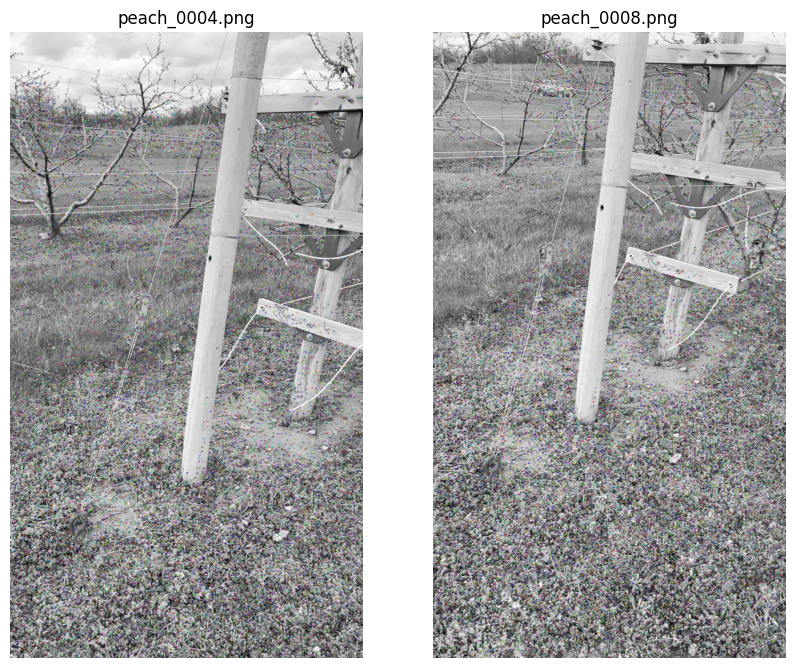

In [ ]:
img_amygardens1_opencv = cv.imread(os.path.join(amygardens_filepath, amygardens1_name), cv.IMREAD_GRAYSCALE)
img_amygardens2_opencv = cv.imread(os.path.join(amygardens_filepath, amygardens2_name), cv.IMREAD_GRAYSCALE)

amygardens1_kps_opencv = [cv.KeyPoint(x=float(x), y=float(y), size=1) for x, y in amygardens1_kps_np]
amygardens2_kps_opencv = [cv.KeyPoint(x=float(x), y=float(y), size=1) for x, y in amygardens2_kps_np]

img_desc_amygardens1 = cv.drawKeypoints(img_amygardens1_opencv, amygardens1_kps_opencv, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_desc_amygardens2 = cv.drawKeypoints(img_amygardens2_opencv, amygardens2_kps_opencv, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, axs = plt.subplots(1,2, figsize=(10, 20))
axs[0].imshow(img_desc_amygardens1)
axs[0].set_title(f"{amygardens1_name}")
axs[0].set_axis_off()

axs[1].imshow(img_desc_amygardens2)
axs[1].set_title(f"{amygardens2_name}")
axs[1].set_axis_off()

plt.show()

In [ ]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)

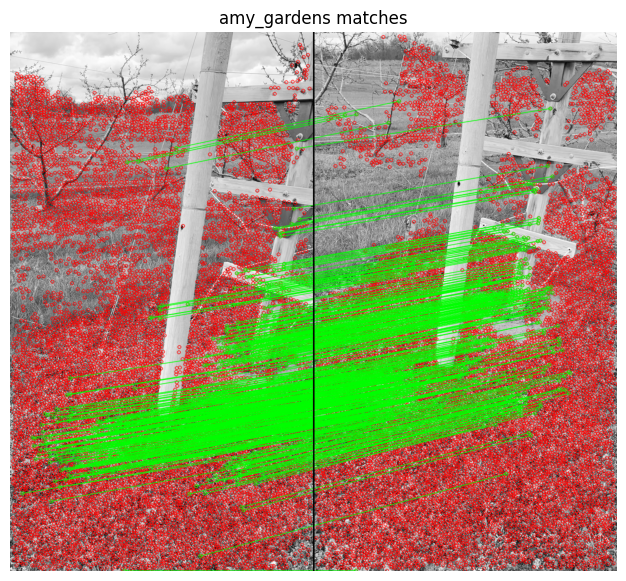

Number of descriptors peach_0004.png: 9567
Number of descriptors peach_0008.png: 9157
Number of matches: 9567
Number of good matches: 432


In [ ]:
amygardens_flann = flann.knnMatch(amygardens1_desc_np, amygardens2_desc_np, k=2)

# Need to draw only good matches, so create a mask
amygardens_masked = [[0,0] for i in range(len(amygardens_flann))]
count_amygardens_good_matches = 0

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(amygardens_flann):
    if m.distance < 0.7*n.distance:
        amygardens_masked[i]=[1,0]
        count_amygardens_good_matches += 1

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = amygardens_masked,
                   flags = cv.DrawMatchesFlags_DEFAULT)

draw_matches = cv.drawMatchesKnn(img_amygardens1_opencv, amygardens1_kps_opencv, img_amygardens2_opencv, amygardens2_kps_opencv, amygardens_flann, None, **draw_params)
x = img_amygardens1_opencv.shape[1]
cv.line(draw_matches, (x,0), (x, draw_matches.shape[0]), (0,0,0), 2)

plt.figure(figsize=(10, 7))
plt.imshow(draw_matches)
plt.axis("off")
plt.title("amy_gardens matches")
plt.show()

print(f"Number of descriptors {amygardens1_name}: {len(amygardens1_desc_np)}")
print(f"Number of descriptors {amygardens2_name}: {len(amygardens2_desc_np)}")
print(f"Number of matches: {len(amygardens_flann)}")
print(f"Number of good matches: {count_amygardens_good_matches}")

## Visualization 2

In [ ]:
heritage_filepath = os.path.join(train_path, "imc2023_heritage")
outlier_name = "outliers_dsc_4473_thumb.png"
cyprus_name = "cyprus_dsc_6488.png"

transform_img = transforms.ToTensor()
img_outlier = Image.open(os.path.join(heritage_filepath, outlier_name)).convert("RGB")
img_outlier = transform_img(img_outlier)
img_outlier = img_outlier.unsqueeze(0).to(device)

img_cyprus = Image.open(os.path.join(heritage_filepath, cyprus_name)).convert("RGB")
img_cyprus = transform_img(img_cyprus)
img_cyprus = img_cyprus.unsqueeze(0).to(device)

In [ ]:
disk = DISK.from_pretrained("depth").to(device)

outlier_disk = disk(img_outlier, pad_if_not_divisible=True)
cyprus_disk = disk(img_cyprus, pad_if_not_divisible=True)

outlier_desc, outlier_kps = outlier_disk[0].descriptors, outlier_disk[0].keypoints
cyprus_desc, cyprus_kps = cyprus_disk[0].descriptors, cyprus_disk[0].keypoints

outlier_desc_np = outlier_desc.cpu().detach().numpy().astype("float32")
outlier_kps_np = outlier_kps.cpu().numpy()

cyprus_desc_np = cyprus_desc.cpu().detach().numpy().astype("float32")
cyprus_kps_np = cyprus_kps.cpu().numpy()

In [ ]:
img_outlier_opencv = cv.imread(os.path.join(heritage_filepath, outlier_name), cv.IMREAD_GRAYSCALE)
img_cyprus_opencv = cv.imread(os.path.join(heritage_filepath, amygardens2_name), cv.IMREAD_GRAYSCALE)

outlier_kps_opencv = [cv.KeyPoint(x=float(x), y=float(y), size=1) for x, y in outlier_kps_np]
cyprus_kps_opencv = [cv.KeyPoint(x=float(x), y=float(y), size=1) for x, y in cyprus_kps_np]

img_desc_outlier = cv.drawKeypoints(img_outlier_opencv, outlier_kps_opencv, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_desc_cyprus = cv.drawKeypoints(img_cyprus_opencv, cyprus_kps_opencv, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, axs = plt.subplots(1,2, figsize=(10, 20))
axs[0].imshow(img_desc_outlier)
axs[0].set_title(f"{outlier_name}")
axs[0].set_axis_off()

axs[1].imshow(img_desc_cyprus)
axs[1].set_title(f"{cyprus_name}")
axs[1].set_axis_off()

plt.show()

In [ ]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)

In [ ]:
heritage_flann = flann.knnMatch(outlier_desc_np, cyprus_desc_np, k=2)

# Need to draw only good matches, so create a mask
heritage_masked = [[0,0] for i in range(len(heritage_flann))]
count_heritage_good_matches = 0

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(heritage_flann):
    if m.distance < 0.7*n.distance:
        heritage_masked[i]=[1,0]
        count_heritage_good_matches += 1

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = heritage_masked,
                   flags = cv.DrawMatchesFlags_DEFAULT)

draw_matches = cv.drawMatchesKnn(img_outlier_opencv, outlier_kps_opencv, img_cyprus_opencv, cyprus_kps_opencv, heritage_flann, None, **draw_params)
x = img_outlier_opencv.shape[1]
cv.line(draw_matches, (x,0), (x, draw_matches.shape[0]), (0,0,0), 2)

plt.figure(figsize=(10, 7))
plt.imshow(draw_matches)
plt.axis("off")
plt.title("imc2023_heritage matches")
plt.show()

print(f"Number of descriptors {outlier_name}: {len(outlier_desc_np)}")
print(f"Number of descriptors {cyprus_name}: {len(cyprus_desc_np)}")
print(f"Number of matches: {len(heritage_flann)}")
print(f"Number of good matches: {count_heritage_good_matches}")